In [16]:

!pip install pandas numpy tensorflow scikit-learn matplotlib seaborn shap




In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import shap
import warnings
import os
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

class DelinquencyPredictor:
    """
    A neural network-based model for predicting delinquency rates or classifying delinquent accounts.
    Supports both regression (continuous delinquency rate) and classification (binary delinquent/not delinquent).
    
    Attributes:
        model: Keras neural network model (initialized in build_model).
        scaler: StandardScaler for feature scaling (initialized in train_model).
        label_encoders: Dictionary of LabelEncoder objects for categorical columns (set in load_and_preprocess_data).
        feature_names: List of feature names after preprocessing (set in load_and_preprocess_data).
        task_type: String indicating task ('classification' or 'regression').
    """
    
    def __init__(self, task_type='classification'):
        """
        Initialize the DelinquencyPredictor.

        Args:
            task_type (str): Task type ('classification' or 'regression'). Default: 'classification'.
        """
        self.model = None
        self.scaler = None
        self.label_encoders = {}
        self.feature_names = None
        self.task_type = task_type
        print(f"Initialized DelinquencyPredictor for {task_type} task")
        print(data[['Location', 'Credit_Card_Type', 'Employment_Status']].nunique())

In [19]:
def load_and_preprocess_data(self, file_path=None, data=None):
    """
    Load and preprocess the dataset for training or prediction.

    Args:
        file_path (str, optional): Path to CSV file containing the dataset.
        data (pd.DataFrame, optional): DataFrame containing the dataset.

    Returns:
        tuple: (X_processed.values, y) where X_processed.values is the preprocessed feature matrix (numpy array)
               and y is the target array (numpy array).

    Behavior:
        - Loads dataset from file_path or data.
        - Falls back to creating a sample dataset if no valid input is provided.
        - Handles missing values (median for numerical, mode for categorical).
        - Sets target as 'Delinquent_Account' for classification or derives 'delinquency_rate' for regression.
        - Drops 'Customer_ID' and applies one-hot encoding to 'Location', 'Credit_Card_Type', 'Employment_Status'.
        - Label encodes 'Month_1' to 'Month_6'.
        - Sets feature_names to match the final preprocessed feature set.
    """
    print("Loading dataset...")
    
    if data is not None:
        df = data
        print(f"Dataset provided directly. Shape: {df.shape}")
    elif file_path and os.path.exists(file_path):
        try:
            df = pd.read_csv(file_path)
            print(f"Dataset loaded successfully. Shape: {df.shape}")
        except Exception as e:
            print(f"Error loading file: {e}")
            print("Creating sample dataset instead...")
            df = self.create_sample_dataset()
    else:
        print("No file path or data provided. Creating sample dataset...")
        df = self.create_sample_dataset()
    
    print("\n" + "="*50)
    print("DATASET INFORMATION")
    print("="*50)
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    print("\nData types:")
    print(df.dtypes)
    print(f"\nMissing values:\n{df.isnull().sum()}")
    
    print("\nHandling missing values...")
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if df[col].isnull().sum() > 0:
            df[col].fillna(df[col].median(), inplace=True)
    
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        if df[col].isnull().sum() > 0:
            df[col].fillna(df[col].mode()[0], inplace=True)
    
    if 'Delinquent_Account' in df.columns and self.task_type == 'classification':
        target_col = 'Delinquent_Account'
        print(f"Using 'Delinquent_Account' as target for classification")
    else:
        print("Deriving delinquency rate from payment history...")
        payment_cols = ['Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6']
        df['delinquency_rate'] = df[payment_cols].apply(
            lambda x: (x.isin(['Late', 'Missed'])).mean(), axis=1
        )
        target_col = 'delinquency_rate'
        print(f"Created 'delinquency_rate' as target for regression")
    
    y = df[target_col].values
    X = df.drop([target_col, 'Customer_ID'] + (['Delinquent_Account'] if target_col == 'delinquency_rate' else []), axis=1)
    
    # Apply one-hot encoding
    X_processed = pd.get_dummies(X, columns=['Location', 'Credit_Card_Type', 'Employment_Status'], prefix=['Location', 'Card', 'Emp'])
    
    # Encode categorical payment history columns
    categorical_columns = ['Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6']
    for column in categorical_columns:
        print(f"Encoding categorical column: {column}")
        le = LabelEncoder()
        X_processed[column] = le.fit_transform(X_processed[column])
        self.label_encoders[column] = le
    
    # Set feature_names after all preprocessing
    self.feature_names = X_processed.columns.tolist()
    print(f"Features: {self.feature_names}")
    print(f"Number of features: {len(self.feature_names)}")
    print(f"X_processed shape: {X_processed.shape}")
    
    if len(self.feature_names) != X_processed.shape[1]:
        raise ValueError(f"Feature names length ({len(self.feature_names)}) does not match X_processed columns ({X_processed.shape[1]})")
    
    print(f"Encoded {len(categorical_columns)} categorical columns")
    
    if self.task_type == 'classification':
        print(f"Target distribution: {np.bincount(y)}")
    else:
        print(f"Target statistics: mean={y.mean():.3f}, std={y.std():.3f}")
    
    return X_processed.values, y

# Add method to class
DelinquencyPredictor.load_and_preprocess_data = load_and_preprocess_data

# Load and preprocess data
predictor = DelinquencyPredictor(task_type='classification')
data = pd.read_csv('Delinquency_prediction_dataset.csv')  # Update path if needed
X, y = predictor.load_and_preprocess_data(data=data)

Initialized DelinquencyPredictor for classification task
Loading dataset...
Dataset provided directly. Shape: (500, 20)

DATASET INFORMATION
Shape: (500, 20)
Columns: ['Customer_ID', 'Age', 'Income', 'Credit_Score', 'Credit_Utilization', 'Missed_Payments', 'Delinquent_Account', 'Loan_Balance', 'Debt_to_Income_Ratio', 'Employment_Status', 'Account_Tenure', 'Credit_Card_Type', 'Location', 'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Unnamed: 19']

Data types:
Customer_ID              object
Age                       int64
Income                  float64
Credit_Score            float64
Credit_Utilization      float64
Missed_Payments           int64
Delinquent_Account        int64
Loan_Balance            float64
Debt_to_Income_Ratio    float64
Employment_Status        object
Account_Tenure            int64
Credit_Card_Type         object
Location                 object
Month_1                  object
Month_2                  object
Month_3                  object
Mont

In [20]:
def create_sample_dataset(self, n_samples=5000):
    """
    Create a synthetic dataset for testing when no real dataset is provided.

    Args:
        n_samples (int): Number of samples to generate. Default: 5000.

    Returns:
        pd.DataFrame: Synthetic dataset with financial features and 'delinquency_rate' target.

    Behavior:
        - Generates realistic financial features (e.g., age, income, credit_score).
        - Clips features to reasonable ranges (e.g., credit_score 300–850).
        - Computes a synthetic 'delinquency_rate' based on a weighted risk score.
    """
    print("Creating sample dataset with realistic financial features...")
    
    np.random.seed(42)
    
    data = {
        'age': np.random.randint(18, 80, n_samples),
        'income': np.random.lognormal(10.5, 0.8, n_samples),
        'employment_years': np.random.exponential(5, n_samples),
        'credit_score': np.random.normal(650, 100, n_samples).astype(int),
        'credit_history_length': np.random.exponential(8, n_samples),
        'number_of_credit_lines': np.random.poisson(4, n_samples),
        'loan_amount': np.random.lognormal(9.5, 0.7, n_samples),
        'loan_term': np.random.choice([12, 24, 36, 48, 60], n_samples),
        'interest_rate': np.random.uniform(5, 25, n_samples),
        'debt_to_income_ratio': np.random.beta(2, 5, n_samples),
        'monthly_payment_ratio': np.random.beta(2, 8, n_samples),
        'education_level': np.random.choice(['high_school', 'bachelor', 'master', 'phd'], n_samples, p=[0.4, 0.35, 0.2, 0.05]),
        'employment_type': np.random.choice(['full_time', 'part_time', 'self_employed', 'unemployed'], n_samples, p=[0.7, 0.15, 0.12, 0.03]),
        'home_ownership': np.random.choice(['rent', 'own', 'mortgage'], n_samples, p=[0.35, 0.25, 0.4]),
        'loan_purpose': np.random.choice(['debt_consolidation', 'home_improvement', 'major_purchase', 'medical', 'other'], n_samples),
        'previous_defaults': np.random.poisson(0.3, n_samples),
        'number_of_dependents': np.random.poisson(1.2, n_samples),
    }
    
    df = pd.DataFrame(data)
    
    df['credit_score'] = np.clip(df['credit_score'], 300, 850)
    df['employment_years'] = np.clip(df['employment_years'], 0, 40)
    df['credit_history_length'] = np.clip(df['credit_history_length'], 0, 30)
    df['debt_to_income_ratio'] = np.clip(df['debt_to_income_ratio'], 0, 1)
    df['monthly_payment_ratio'] = np.clip(df['monthly_payment_ratio'], 0, 0.5)
    
    risk_score = (
        0.25 * (1 - (df['credit_score'] - 300) / 550) +
        0.20 * df['debt_to_income_ratio'] +
        0.15 * df['monthly_payment_ratio'] +
        0.10 * (df['age'] < 25).astype(int) +
        0.08 * (df['employment_type'] == 'unemployed').astype(int) +
        0.07 * (df['previous_defaults'] > 0).astype(int) +
        0.05 * (df['loan_term'] > 48).astype(int) +
        0.05 * (df['interest_rate'] > 15).astype(int) +
        0.05 * np.random.random(n_samples)
    )
    
    delinquency_rate = np.clip(risk_score + np.random.normal(0, 0.1, n_samples), 0, 1)
    df['delinquency_rate'] = delinquency_rate
    
    print(f"Sample dataset created with {n_samples} rows and {len(df.columns)} columns")
    print(f"Average delinquency rate: {delinquency_rate.mean():.3f}")
    
    return df

# Add method to class
DelinquencyPredictor.create_sample_dataset = create_sample_dataset

In [21]:
def build_model(self, input_dim):
    """
    Build and compile a Keras neural network model.

    Args:
        input_dim (int): Number of input features.

    Returns:
        keras.Sequential Model: Compiled neural network model.

    Behavior:
        - Creates a model with 3 hidden layers (64, 32, 16 neurons) with ReLU activation, L2 regularization, batch normalization, and dropout.
        - Output layer uses sigmoid activation (1 neuron).
        - Compiles with binary_crossentropy loss and Adam optimizer for classification, or MSE loss for regression.
    """
    print(f"\nBuilding neural network for {self.task_type}...")
    print(f"Input dimension: {input_dim}")
    
    model = keras.Sequential([
        layers.Dense(64, input_shape=(input_dim,), activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(16, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
        layers.Dropout(0.1),
        layers.Dense(1, activation='sigmoid')
    ])
    
    if self.task_type == 'classification':
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
        )
    else:
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss='mean_squared_error',
            metrics=['mae', 'mse']
        )
    
    print("\nModel Architecture:")
    model.summary()
    
    return model

# Add method to class
DelinquencyPredictor.build_model = build_model


In [22]:
def train_model(self, X, y, validation_split=0.2, epochs=100, batch_size=64):
    """
    Train the neural network model.

    Args:
        X (np.ndarray): Feature matrix.
        y (np.ndarray): Target array.
        validation_split (float): Fraction of data for validation. Default: 0.2.
        epochs (int): Maximum number of training epochs. Default: 100.
        batch_size (int): Batch size for training. Default: 64.

    Returns:
        keras.callbacks.History: Training history object containing loss and metrics.

    Behavior:
        - Scales features using StandardScaler.
        - Builds and trains the model with early stopping, learning rate reduction, and model checkpointing.
        - Uses class weights for classification to handle imbalanced data.
    """
    print(f"\n{'='*50}")
    print("TRAINING THE MODEL")
    print(f"{'='*50}")
    
    print("Scaling features...")
    self.scaler = StandardScaler()
    X_scaled = self.scaler.fit_transform(X)
    
    print(f"Feature scaling completed. Mean: {X_scaled.mean():.3f}, Std: {X_scaled.std():.3f}")
    
    self.model = self.build_model(X_scaled.shape[1])
    
    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True,
            verbose=1
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=10,
            min_lr=0.00001,
            verbose=1
        ),
        keras.callbacks.ModelCheckpoint(
            'best_model.h5',
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        )
    ]
    
    print(f"Starting training with {len(X_scaled)} samples...")
    print(f"Validation split: {validation_split}")
    print(f"Batch size: {batch_size}")
    print(f"Max epochs: {epochs}")
    
    if self.task_type == 'classification':
        from sklearn.utils.class_weight import compute_class_weight
        class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
        class_weight_dict = dict(enumerate(class_weights))
        history = self.model.fit(
            X_scaled, y,
            validation_split=validation_split,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            class_weight=class_weight_dict,
            verbose=1
        )
    else:
        history = self.model.fit(
            X_scaled, y,
            validation_split=validation_split,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=1
        )
    
    print("\nTraining completed!")
    return history

# Add method to class
DelinquencyPredictor.train_model = train_model

# Split data and train
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y if predictor.task_type == 'classification' else None
)
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Features: {len(predictor.feature_names)}")

history = predictor.train_model(X_train, y_train, validation_split=0.2, epochs=100, batch_size=64)


Training samples: 400
Test samples: 100
Features: 31

TRAINING THE MODEL
Scaling features...
Feature scaling completed. Mean: 0.000, Std: 0.984

Building neural network for classification...
Input dimension: 31

Model Architecture:


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_26 (Dense)                │ (None, 64)             │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,057 (19.75 KB)

 Trainable params: 4,865 (19.00 KB)

 Non-trainable params: 192 (768.00 B)

Starting training with 400 samples...
Validation split: 0.2
Batch size: 64
Max epochs: 100
Epoch 1/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.5625 - loss: 2.0604 - precision_6: 0.1852 - recall_6: 0.4545
Epoch 1: val_loss improved from inf to 1.72596, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.5065 - loss: 1.9362 - precision_6: 0.1625 - recall_6: 0.5124 - val_accuracy: 0.5500 - val_loss: 1.7260 - val_precision_6: 0.1429 - val_recall_6: 0.2500 - learning_rate: 0.0010
Epoch 2/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5938 - loss: 1.8470 - precision_6: 0.2222 - recall_6: 0.5455
Epoch 2: val_loss improved from 1.72596 to 1.71412, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5178 - loss: 1.8396 - precision_6: 0.1752 - recall_6: 0.5516 - val_accuracy: 0.5750 - val_loss: 1.7141 - val_precision_6: 0.1250 - val_recall_6: 0.1875 - learning_rate: 0.0010
Epoch 3/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5625 - loss: 1.8066 - precision_6: 0.2069 - recall_6: 0.5455
Epoch 3: val_loss improved from 1.71412 to 1.70094, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5296 - loss: 1.7669 - precision_6: 0.1976 - recall_6: 0.6536 - val_accuracy: 0.6000 - val_loss: 1.7009 - val_precision_6: 0.1923 - val_recall_6: 0.3125 - learning_rate: 0.0010
Epoch 4/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3906 - loss: 1.7990 - precision_6: 0.1316 - recall_6: 0.4545
Epoch 4: val_loss improved from 1.70094 to 1.68592, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4635 - loss: 1.7549 - precision_6: 0.1509 - recall_6: 0.5229 - val_accuracy: 0.6000 - val_loss: 1.6859 - val_precision_6: 0.1923 - val_recall_6: 0.3125 - learning_rate: 0.0010
Epoch 5/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5312 - loss: 1.6758 - precision_6: 0.2121 - recall_6: 0.6364
Epoch 5: val_loss improved from 1.68592 to 1.67110, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5302 - loss: 1.6630 - precision_6: 0.1957 - recall_6: 0.6427 - val_accuracy: 0.6000 - val_loss: 1.6711 - val_precision_6: 0.1923 - val_recall_6: 0.3125 - learning_rate: 0.0010
Epoch 6/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5156 - loss: 1.6487 - precision_6: 0.2222 - recall_6: 0.7273
Epoch 6: val_loss improved from 1.67110 to 1.65875, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5148 - loss: 1.6757 - precision_6: 0.2018 - recall_6: 0.7087 - val_accuracy: 0.6000 - val_loss: 1.6587 - val_precision_6: 0.1923 - val_recall_6: 0.3125 - learning_rate: 0.0010
Epoch 7/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6406 - loss: 1.7357 - precision_6: 0.2500 - recall_6: 0.5455
Epoch 7: val_loss improved from 1.65875 to 1.65038, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5708 - loss: 1.7121 - precision_6: 0.2029 - recall_6: 0.5854 - val_accuracy: 0.6000 - val_loss: 1.6504 - val_precision_6: 0.2143 - val_recall_6: 0.3750 - learning_rate: 0.0010
Epoch 8/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6094 - loss: 1.5342 - precision_6: 0.2941 - recall_6: 0.9091
Epoch 8: val_loss improved from 1.65038 to 1.64091, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5884 - loss: 1.5863 - precision_6: 0.2401 - recall_6: 0.7525 - val_accuracy: 0.6000 - val_loss: 1.6409 - val_precision_6: 0.2333 - val_recall_6: 0.4375 - learning_rate: 0.0010
Epoch 9/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5625 - loss: 1.6604 - precision_6: 0.2069 - recall_6: 0.5455
Epoch 9: val_loss improved from 1.64091 to 1.62925, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5578 - loss: 1.6625 - precision_6: 0.1898 - recall_6: 0.5563 - val_accuracy: 0.5875 - val_loss: 1.6292 - val_precision_6: 0.2258 - val_recall_6: 0.4375 - learning_rate: 0.0010
Epoch 10/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4688 - loss: 1.7054 - precision_6: 0.1515 - recall_6: 0.4545
Epoch 10: val_loss improved from 1.62925 to 1.61754, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5689 - loss: 1.6211 - precision_6: 0.2114 - recall_6: 0.6379 - val_accuracy: 0.5875 - val_loss: 1.6175 - val_precision_6: 0.2424 - val_recall_6: 0.5000 - learning_rate: 0.0010
Epoch 11/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5938 - loss: 1.5601 - precision_6: 0.2581 - recall_6: 0.7273
Epoch 11: val_loss improved from 1.61754 to 1.60329, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5978 - loss: 1.5772 - precision_6: 0.2240 - recall_6: 0.6341 - val_accuracy: 0.5875 - val_loss: 1.6033 - val_precision_6: 0.2424 - val_recall_6: 0.5000 - learning_rate: 0.0010
Epoch 12/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5938 - loss: 1.5734 - precision_6: 0.2414 - recall_6: 0.6364
Epoch 12: val_loss improved from 1.60329 to 1.58994, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5891 - loss: 1.5686 - precision_6: 0.2266 - recall_6: 0.6704 - val_accuracy: 0.6000 - val_loss: 1.5899 - val_precision_6: 0.2647 - val_recall_6: 0.5625 - learning_rate: 0.0010
Epoch 13/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6094 - loss: 1.5765 - precision_6: 0.2308 - recall_6: 0.5455
Epoch 13: val_loss improved from 1.58994 to 1.57734, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5884 - loss: 1.5459 - precision_6: 0.2164 - recall_6: 0.6183 - val_accuracy: 0.6125 - val_loss: 1.5773 - val_precision_6: 0.2727 - val_recall_6: 0.5625 - learning_rate: 0.0010
Epoch 14/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6562 - loss: 1.6329 - precision_6: 0.2800 - recall_6: 0.6364
Epoch 14: val_loss improved from 1.57734 to 1.56621, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6224 - loss: 1.5654 - precision_6: 0.2403 - recall_6: 0.6466 - val_accuracy: 0.6125 - val_loss: 1.5662 - val_precision_6: 0.2857 - val_recall_6: 0.6250 - learning_rate: 0.0010
Epoch 15/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6250 - loss: 1.5146 - precision_6: 0.2593 - recall_6: 0.6364
Epoch 15: val_loss improved from 1.56621 to 1.55496, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6502 - loss: 1.4813 - precision_6: 0.2667 - recall_6: 0.7021 - val_accuracy: 0.6125 - val_loss: 1.5550 - val_precision_6: 0.2857 - val_recall_6: 0.6250 - learning_rate: 0.0010
Epoch 16/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6250 - loss: 1.4544 - precision_6: 0.3030 - recall_6: 0.9091
Epoch 16: val_loss improved from 1.55496 to 1.54448, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6340 - loss: 1.4777 - precision_6: 0.2698 - recall_6: 0.7842 - val_accuracy: 0.6125 - val_loss: 1.5445 - val_precision_6: 0.2857 - val_recall_6: 0.6250 - learning_rate: 0.0010
Epoch 17/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5938 - loss: 1.5361 - precision_6: 0.2222 - recall_6: 0.5455
Epoch 17: val_loss improved from 1.54448 to 1.53660, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6280 - loss: 1.4940 - precision_6: 0.2427 - recall_6: 0.6487 - val_accuracy: 0.6125 - val_loss: 1.5366 - val_precision_6: 0.2857 - val_recall_6: 0.6250 - learning_rate: 0.0010
Epoch 18/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7812 - loss: 1.4060 - precision_6: 0.4286 - recall_6: 0.8182
Epoch 18: val_loss improved from 1.53660 to 1.52876, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7336 - loss: 1.4102 - precision_6: 0.3543 - recall_6: 0.8354 - val_accuracy: 0.5875 - val_loss: 1.5288 - val_precision_6: 0.2703 - val_recall_6: 0.6250 - learning_rate: 0.0010
Epoch 19/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6875 - loss: 1.4436 - precision_6: 0.3200 - recall_6: 0.7273
Epoch 19: val_loss improved from 1.52876 to 1.52012, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6786 - loss: 1.4167 - precision_6: 0.2890 - recall_6: 0.7183 - val_accuracy: 0.5875 - val_loss: 1.5201 - val_precision_6: 0.2703 - val_recall_6: 0.6250 - learning_rate: 0.0010
Epoch 20/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7188 - loss: 1.4397 - precision_6: 0.3333 - recall_6: 0.6364
Epoch 20: val_loss improved from 1.52012 to 1.51248, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6743 - loss: 1.4218 - precision_6: 0.2845 - recall_6: 0.7018 - val_accuracy: 0.5750 - val_loss: 1.5125 - val_precision_6: 0.2632 - val_recall_6: 0.6250 - learning_rate: 0.0010
Epoch 21/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7500 - loss: 1.3882 - precision_6: 0.4000 - recall_6: 0.9091
Epoch 21: val_loss improved from 1.51248 to 1.50409, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7014 - loss: 1.3928 - precision_6: 0.3307 - recall_6: 0.8693 - val_accuracy: 0.5750 - val_loss: 1.5041 - val_precision_6: 0.2632 - val_recall_6: 0.6250 - learning_rate: 0.0010
Epoch 22/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7656 - loss: 1.2961 - precision_6: 0.4167 - recall_6: 0.9091
Epoch 22: val_loss improved from 1.50409 to 1.49450, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7046 - loss: 1.3490 - precision_6: 0.3243 - recall_6: 0.8073 - val_accuracy: 0.5625 - val_loss: 1.4945 - val_precision_6: 0.2432 - val_recall_6: 0.5625 - learning_rate: 0.0010
Epoch 23/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6406 - loss: 1.4467 - precision_6: 0.2500 - recall_6: 0.5455
Epoch 23: val_loss improved from 1.49450 to 1.48495, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7007 - loss: 1.3869 - precision_6: 0.3040 - recall_6: 0.7051 - val_accuracy: 0.5625 - val_loss: 1.4849 - val_precision_6: 0.2432 - val_recall_6: 0.5625 - learning_rate: 0.0010
Epoch 24/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7344 - loss: 1.3217 - precision_6: 0.3750 - recall_6: 0.8182
Epoch 24: val_loss improved from 1.48495 to 1.47473, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7367 - loss: 1.3222 - precision_6: 0.3598 - recall_6: 0.8704 - val_accuracy: 0.5750 - val_loss: 1.4747 - val_precision_6: 0.2632 - val_recall_6: 0.6250 - learning_rate: 0.0010
Epoch 25/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7500 - loss: 1.3634 - precision_6: 0.3810 - recall_6: 0.7273
Epoch 25: val_loss improved from 1.47473 to 1.46452, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7030 - loss: 1.3462 - precision_6: 0.3172 - recall_6: 0.7628 - val_accuracy: 0.5625 - val_loss: 1.4645 - val_precision_6: 0.2564 - val_recall_6: 0.6250 - learning_rate: 0.0010
Epoch 26/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8125 - loss: 1.2239 - precision_6: 0.4783 - recall_6: 1.0000
Epoch 26: val_loss improved from 1.46452 to 1.45349, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7351 - loss: 1.2891 - precision_6: 0.3642 - recall_6: 0.8970 - val_accuracy: 0.5750 - val_loss: 1.4535 - val_precision_6: 0.2632 - val_recall_6: 0.6250 - learning_rate: 0.0010
Epoch 27/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7812 - loss: 1.2741 - precision_6: 0.4348 - recall_6: 0.9091
Epoch 27: val_loss improved from 1.45349 to 1.44291, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7358 - loss: 1.2864 - precision_6: 0.3562 - recall_6: 0.8410 - val_accuracy: 0.5625 - val_loss: 1.4429 - val_precision_6: 0.2432 - val_recall_6: 0.5625 - learning_rate: 0.0010
Epoch 28/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7656 - loss: 1.3179 - precision_6: 0.4091 - recall_6: 0.8182
Epoch 28: val_loss improved from 1.44291 to 1.43240, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7622 - loss: 1.2883 - precision_6: 0.3833 - recall_6: 0.8393 - val_accuracy: 0.5625 - val_loss: 1.4324 - val_precision_6: 0.2432 - val_recall_6: 0.5625 - learning_rate: 0.0010
Epoch 29/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7656 - loss: 1.2856 - precision_6: 0.4091 - recall_6: 0.8182
Epoch 29: val_loss improved from 1.43240 to 1.42370, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7431 - loss: 1.2724 - precision_6: 0.3640 - recall_6: 0.8423 - val_accuracy: 0.5625 - val_loss: 1.4237 - val_precision_6: 0.2432 - val_recall_6: 0.5625 - learning_rate: 0.0010
Epoch 30/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6719 - loss: 1.3841 - precision_6: 0.2917 - recall_6: 0.6364
Epoch 30: val_loss improved from 1.42370 to 1.41500, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7032 - loss: 1.3162 - precision_6: 0.3083 - recall_6: 0.7169 - val_accuracy: 0.5750 - val_loss: 1.4150 - val_precision_6: 0.2500 - val_recall_6: 0.5625 - learning_rate: 0.0010
Epoch 31/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7812 - loss: 1.2422 - precision_6: 0.4286 - recall_6: 0.8182
Epoch 31: val_loss improved from 1.41500 to 1.40677, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7410 - loss: 1.2480 - precision_6: 0.3601 - recall_6: 0.8265 - val_accuracy: 0.5750 - val_loss: 1.4068 - val_precision_6: 0.2500 - val_recall_6: 0.5625 - learning_rate: 0.0010
Epoch 32/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6875 - loss: 1.2658 - precision_6: 0.3333 - recall_6: 0.8182
Epoch 32: val_loss improved from 1.40677 to 1.39763, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7496 - loss: 1.2258 - precision_6: 0.3730 - recall_6: 0.8634 - val_accuracy: 0.5625 - val_loss: 1.3976 - val_precision_6: 0.2286 - val_recall_6: 0.5000 - learning_rate: 0.0010
Epoch 33/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8125 - loss: 1.2403 - precision_6: 0.4667 - recall_6: 0.6364
Epoch 33: val_loss improved from 1.39763 to 1.38738, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7711 - loss: 1.2199 - precision_6: 0.3882 - recall_6: 0.7562 - val_accuracy: 0.5625 - val_loss: 1.3874 - val_precision_6: 0.2286 - val_recall_6: 0.5000 - learning_rate: 0.0010
Epoch 34/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7969 - loss: 1.1535 - precision_6: 0.4583 - recall_6: 1.0000
Epoch 34: val_loss improved from 1.38738 to 1.37739, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7820 - loss: 1.1710 - precision_6: 0.4096 - recall_6: 0.8943 - val_accuracy: 0.5500 - val_loss: 1.3774 - val_precision_6: 0.2059 - val_recall_6: 0.4375 - learning_rate: 0.0010
Epoch 35/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8281 - loss: 1.1656 - precision_6: 0.5000 - recall_6: 1.0000
Epoch 35: val_loss improved from 1.37739 to 1.36790, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7670 - loss: 1.1907 - precision_6: 0.3940 - recall_6: 0.8911 - val_accuracy: 0.5375 - val_loss: 1.3679 - val_precision_6: 0.2000 - val_recall_6: 0.4375 - learning_rate: 0.0010
Epoch 36/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8438 - loss: 1.1740 - precision_6: 0.5333 - recall_6: 0.7273
Epoch 36: val_loss improved from 1.36790 to 1.35967, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7925 - loss: 1.1608 - precision_6: 0.4204 - recall_6: 0.7912 - val_accuracy: 0.5500 - val_loss: 1.3597 - val_precision_6: 0.2222 - val_recall_6: 0.5000 - learning_rate: 0.0010
Epoch 37/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7969 - loss: 1.1735 - precision_6: 0.4545 - recall_6: 0.9091
Epoch 37: val_loss improved from 1.35967 to 1.35165, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7608 - loss: 1.1885 - precision_6: 0.3842 - recall_6: 0.8614 - val_accuracy: 0.5625 - val_loss: 1.3517 - val_precision_6: 0.2432 - val_recall_6: 0.5625 - learning_rate: 0.0010
Epoch 38/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8750 - loss: 1.1784 - precision_6: 0.6000 - recall_6: 0.8182
Epoch 38: val_loss improved from 1.35165 to 1.34490, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7999 - loss: 1.1625 - precision_6: 0.4355 - recall_6: 0.7918 - val_accuracy: 0.5750 - val_loss: 1.3449 - val_precision_6: 0.2500 - val_recall_6: 0.5625 - learning_rate: 0.0010
Epoch 39/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8125 - loss: 1.1540 - precision_6: 0.4762 - recall_6: 0.9091
Epoch 39: val_loss improved from 1.34490 to 1.33698, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7669 - loss: 1.1510 - precision_6: 0.3968 - recall_6: 0.9129 - val_accuracy: 0.5750 - val_loss: 1.3370 - val_precision_6: 0.2500 - val_recall_6: 0.5625 - learning_rate: 0.0010
Epoch 40/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8438 - loss: 1.0942 - precision_6: 0.5238 - recall_6: 1.0000
Epoch 40: val_loss improved from 1.33698 to 1.32867, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8115 - loss: 1.1202 - precision_6: 0.4531 - recall_6: 0.9528 - val_accuracy: 0.5750 - val_loss: 1.3287 - val_precision_6: 0.2500 - val_recall_6: 0.5625 - learning_rate: 0.0010
Epoch 41/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7500 - loss: 1.2226 - precision_6: 0.3684 - recall_6: 0.6364
Epoch 41: val_loss improved from 1.32867 to 1.32080, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7627 - loss: 1.1562 - precision_6: 0.3770 - recall_6: 0.7873 - val_accuracy: 0.5875 - val_loss: 1.3208 - val_precision_6: 0.2571 - val_recall_6: 0.5625 - learning_rate: 0.0010
Epoch 42/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9062 - loss: 1.0437 - precision_6: 0.6471 - recall_6: 1.0000
Epoch 42: val_loss improved from 1.32080 to 1.31334, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8374 - loss: 1.0668 - precision_6: 0.4957 - recall_6: 0.9347 - val_accuracy: 0.5750 - val_loss: 1.3133 - val_precision_6: 0.2353 - val_recall_6: 0.5000 - learning_rate: 0.0010
Epoch 43/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7812 - loss: 1.1023 - precision_6: 0.4211 - recall_6: 0.7273
Epoch 43: val_loss improved from 1.31334 to 1.30476, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7911 - loss: 1.0659 - precision_6: 0.4183 - recall_6: 0.8443 - val_accuracy: 0.5875 - val_loss: 1.3048 - val_precision_6: 0.2424 - val_recall_6: 0.5000 - learning_rate: 0.0010
Epoch 44/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8750 - loss: 1.0718 - precision_6: 0.5882 - recall_6: 0.9091
Epoch 44: val_loss improved from 1.30476 to 1.29674, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8178 - loss: 1.0587 - precision_6: 0.4622 - recall_6: 0.8865 - val_accuracy: 0.5875 - val_loss: 1.2967 - val_precision_6: 0.2424 - val_recall_6: 0.5000 - learning_rate: 0.0010
Epoch 45/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8281 - loss: 1.0396 - precision_6: 0.5000 - recall_6: 0.9091
Epoch 45: val_loss improved from 1.29674 to 1.29057, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7882 - loss: 1.0821 - precision_6: 0.4118 - recall_6: 0.8109 - val_accuracy: 0.5875 - val_loss: 1.2906 - val_precision_6: 0.2424 - val_recall_6: 0.5000 - learning_rate: 0.0010
Epoch 46/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8906 - loss: 0.9833 - precision_6: 0.6111 - recall_6: 1.0000
Epoch 46: val_loss improved from 1.29057 to 1.28612, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8323 - loss: 1.0197 - precision_6: 0.4888 - recall_6: 0.9459 - val_accuracy: 0.5875 - val_loss: 1.2861 - val_precision_6: 0.2424 - val_recall_6: 0.5000 - learning_rate: 0.0010
Epoch 47/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8750 - loss: 0.9937 - precision_6: 0.6000 - recall_6: 0.8182
Epoch 47: val_loss improved from 1.28612 to 1.27989, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8470 - loss: 1.0094 - precision_6: 0.5104 - recall_6: 0.8885 - val_accuracy: 0.6000 - val_loss: 1.2799 - val_precision_6: 0.2500 - val_recall_6: 0.5000 - learning_rate: 0.0010
Epoch 48/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8438 - loss: 1.0263 - precision_6: 0.5263 - recall_6: 0.9091
Epoch 48: val_loss improved from 1.27989 to 1.27060, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8045 - loss: 1.0296 - precision_6: 0.4421 - recall_6: 0.9070 - val_accuracy: 0.6125 - val_loss: 1.2706 - val_precision_6: 0.2581 - val_recall_6: 0.5000 - learning_rate: 0.0010
Epoch 49/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8750 - loss: 0.9504 - precision_6: 0.6000 - recall_6: 0.8182
Epoch 49: val_loss improved from 1.27060 to 1.26054, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8320 - loss: 1.0129 - precision_6: 0.4832 - recall_6: 0.8301 - val_accuracy: 0.6000 - val_loss: 1.2605 - val_precision_6: 0.2333 - val_recall_6: 0.4375 - learning_rate: 0.0010
Epoch 50/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8125 - loss: 0.9563 - precision_6: 0.4783 - recall_6: 1.0000
Epoch 50: val_loss improved from 1.26054 to 1.25128, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8046 - loss: 0.9647 - precision_6: 0.4441 - recall_6: 0.9753 - val_accuracy: 0.5875 - val_loss: 1.2513 - val_precision_6: 0.2069 - val_recall_6: 0.3750 - learning_rate: 0.0010
Epoch 51/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9062 - loss: 0.9490 - precision_6: 0.6471 - recall_6: 1.0000
Epoch 51: val_loss improved from 1.25128 to 1.24220, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8523 - loss: 0.9594 - precision_6: 0.5185 - recall_6: 0.9683 - val_accuracy: 0.5875 - val_loss: 1.2422 - val_precision_6: 0.2069 - val_recall_6: 0.3750 - learning_rate: 0.0010
Epoch 52/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9375 - loss: 0.8786 - precision_6: 0.7333 - recall_6: 1.0000
Epoch 52: val_loss improved from 1.24220 to 1.23531, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8810 - loss: 0.9179 - precision_6: 0.5743 - recall_6: 0.9776 - val_accuracy: 0.5875 - val_loss: 1.2353 - val_precision_6: 0.2258 - val_recall_6: 0.4375 - learning_rate: 0.0010
Epoch 53/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8906 - loss: 0.9462 - precision_6: 0.6250 - recall_6: 0.9091
Epoch 53: val_loss improved from 1.23531 to 1.22954, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8585 - loss: 0.9319 - precision_6: 0.5298 - recall_6: 0.9429 - val_accuracy: 0.6000 - val_loss: 1.2295 - val_precision_6: 0.2333 - val_recall_6: 0.4375 - learning_rate: 0.0010
Epoch 54/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8906 - loss: 0.8937 - precision_6: 0.6250 - recall_6: 0.9091
Epoch 54: val_loss improved from 1.22954 to 1.22304, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8497 - loss: 0.9308 - precision_6: 0.5151 - recall_6: 0.9129 - val_accuracy: 0.6125 - val_loss: 1.2230 - val_precision_6: 0.2414 - val_recall_6: 0.4375 - learning_rate: 0.0010
Epoch 55/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8906 - loss: 0.8996 - precision_6: 0.6111 - recall_6: 1.0000
Epoch 55: val_loss improved from 1.22304 to 1.21735, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8610 - loss: 0.9071 - precision_6: 0.5313 - recall_6: 0.9657 - val_accuracy: 0.6125 - val_loss: 1.2174 - val_precision_6: 0.2414 - val_recall_6: 0.4375 - learning_rate: 0.0010
Epoch 56/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9062 - loss: 0.9768 - precision_6: 0.7273 - recall_6: 0.7273
Epoch 56: val_loss improved from 1.21735 to 1.21256, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8598 - loss: 0.9301 - precision_6: 0.5473 - recall_6: 0.8552 - val_accuracy: 0.6250 - val_loss: 1.2126 - val_precision_6: 0.2667 - val_recall_6: 0.5000 - learning_rate: 0.0010
Epoch 57/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8594 - loss: 0.8871 - precision_6: 0.5500 - recall_6: 1.0000
Epoch 57: val_loss improved from 1.21256 to 1.20864, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8413 - loss: 0.8966 - precision_6: 0.4964 - recall_6: 0.9571 - val_accuracy: 0.6375 - val_loss: 1.2086 - val_precision_6: 0.2759 - val_recall_6: 0.5000 - learning_rate: 0.0010
Epoch 58/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8750 - loss: 0.9143 - precision_6: 0.5882 - recall_6: 0.9091
Epoch 58: val_loss improved from 1.20864 to 1.20418, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8629 - loss: 0.8912 - precision_6: 0.5361 - recall_6: 0.9601 - val_accuracy: 0.6375 - val_loss: 1.2042 - val_precision_6: 0.2759 - val_recall_6: 0.5000 - learning_rate: 0.0010
Epoch 59/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8594 - loss: 0.8943 - precision_6: 0.5556 - recall_6: 0.9091
Epoch 59: val_loss improved from 1.20418 to 1.20153, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8326 - loss: 0.9218 - precision_6: 0.4821 - recall_6: 0.8845 - val_accuracy: 0.6375 - val_loss: 1.2015 - val_precision_6: 0.2759 - val_recall_6: 0.5000 - learning_rate: 0.0010
Epoch 60/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8594 - loss: 0.9103 - precision_6: 0.5556 - recall_6: 0.9091
Epoch 60: val_loss improved from 1.20153 to 1.19579, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8618 - loss: 0.8930 - precision_6: 0.5349 - recall_6: 0.9126 - val_accuracy: 0.6500 - val_loss: 1.1958 - val_precision_6: 0.2857 - val_recall_6: 0.5000 - learning_rate: 0.0010
Epoch 61/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8281 - loss: 0.8989 - precision_6: 0.5000 - recall_6: 0.9091
Epoch 61: val_loss improved from 1.19579 to 1.19086, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8230 - loss: 0.9032 - precision_6: 0.4639 - recall_6: 0.8317 - val_accuracy: 0.6500 - val_loss: 1.1909 - val_precision_6: 0.2692 - val_recall_6: 0.4375 - learning_rate: 0.0010
Epoch 62/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8906 - loss: 0.8572 - precision_6: 0.6111 - recall_6: 1.0000
Epoch 62: val_loss improved from 1.19086 to 1.18630, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8749 - loss: 0.8563 - precision_6: 0.5577 - recall_6: 0.9620 - val_accuracy: 0.6500 - val_loss: 1.1863 - val_precision_6: 0.2692 - val_recall_6: 0.4375 - learning_rate: 0.0010
Epoch 63/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9062 - loss: 0.8167 - precision_6: 0.6667 - recall_6: 0.9091
Epoch 63: val_loss improved from 1.18630 to 1.17870, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8654 - loss: 0.8265 - precision_6: 0.5440 - recall_6: 0.9532 - val_accuracy: 0.6625 - val_loss: 1.1787 - val_precision_6: 0.2800 - val_recall_6: 0.4375 - learning_rate: 0.0010
Epoch 64/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9219 - loss: 0.7983 - precision_6: 0.6875 - recall_6: 1.0000
Epoch 64: val_loss improved from 1.17870 to 1.16833, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8785 - loss: 0.8107 - precision_6: 0.5669 - recall_6: 0.9888 - val_accuracy: 0.6625 - val_loss: 1.1683 - val_precision_6: 0.2800 - val_recall_6: 0.4375 - learning_rate: 0.0010
Epoch 65/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8594 - loss: 0.8314 - precision_6: 0.5625 - recall_6: 0.8182
Epoch 65: val_loss improved from 1.16833 to 1.16381, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8709 - loss: 0.8296 - precision_6: 0.5560 - recall_6: 0.8955 - val_accuracy: 0.6625 - val_loss: 1.1638 - val_precision_6: 0.2800 - val_recall_6: 0.4375 - learning_rate: 0.0010
Epoch 66/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8906 - loss: 0.7818 - precision_6: 0.6111 - recall_6: 1.0000
Epoch 66: val_loss improved from 1.16381 to 1.15852, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8945 - loss: 0.7994 - precision_6: 0.6017 - recall_6: 0.9604 - val_accuracy: 0.6750 - val_loss: 1.1585 - val_precision_6: 0.2917 - val_recall_6: 0.4375 - learning_rate: 0.0010
Epoch 67/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9062 - loss: 0.7746 - precision_6: 0.6667 - recall_6: 0.9091
Epoch 67: val_loss improved from 1.15852 to 1.15156, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8674 - loss: 0.7914 - precision_6: 0.5486 - recall_6: 0.9284 - val_accuracy: 0.6875 - val_loss: 1.1516 - val_precision_6: 0.3043 - val_recall_6: 0.4375 - learning_rate: 0.0010
Epoch 68/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9219 - loss: 0.8303 - precision_6: 0.7143 - recall_6: 0.9091
Epoch 68: val_loss improved from 1.15156 to 1.14511, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8970 - loss: 0.8057 - precision_6: 0.6136 - recall_6: 0.9377 - val_accuracy: 0.6875 - val_loss: 1.1451 - val_precision_6: 0.3043 - val_recall_6: 0.4375 - learning_rate: 0.0010
Epoch 69/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9375 - loss: 0.7506 - precision_6: 0.7333 - recall_6: 1.0000
Epoch 69: val_loss improved from 1.14511 to 1.14158, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8835 - loss: 0.8015 - precision_6: 0.5826 - recall_6: 0.9221 - val_accuracy: 0.6875 - val_loss: 1.1416 - val_precision_6: 0.3043 - val_recall_6: 0.4375 - learning_rate: 0.0010
Epoch 70/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8750 - loss: 0.7487 - precision_6: 0.5882 - recall_6: 0.9091
Epoch 70: val_loss improved from 1.14158 to 1.13736, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8814 - loss: 0.7622 - precision_6: 0.5765 - recall_6: 0.9205 - val_accuracy: 0.6875 - val_loss: 1.1374 - val_precision_6: 0.3043 - val_recall_6: 0.4375 - learning_rate: 0.0010
Epoch 71/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8750 - loss: 0.7841 - precision_6: 0.5789 - recall_6: 1.0000
Epoch 71: val_loss improved from 1.13736 to 1.13449, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8834 - loss: 0.7763 - precision_6: 0.5759 - recall_6: 0.9706 - val_accuracy: 0.6625 - val_loss: 1.1345 - val_precision_6: 0.2609 - val_recall_6: 0.3750 - learning_rate: 0.0010
Epoch 72/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8750 - loss: 0.7702 - precision_6: 0.5882 - recall_6: 0.9091
Epoch 72: val_loss improved from 1.13449 to 1.13349, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8773 - loss: 0.7675 - precision_6: 0.5663 - recall_6: 0.9248 - val_accuracy: 0.6625 - val_loss: 1.1335 - val_precision_6: 0.2800 - val_recall_6: 0.4375 - learning_rate: 0.0010
Epoch 73/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8750 - loss: 0.7751 - precision_6: 0.5882 - recall_6: 0.9091
Epoch 73: val_loss improved from 1.13349 to 1.13172, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8797 - loss: 0.7468 - precision_6: 0.5700 - recall_6: 0.9489 - val_accuracy: 0.6625 - val_loss: 1.1317 - val_precision_6: 0.2800 - val_recall_6: 0.4375 - learning_rate: 0.0010
Epoch 74/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9375 - loss: 0.6989 - precision_6: 0.7333 - recall_6: 1.0000
Epoch 74: val_loss improved from 1.13172 to 1.12712, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9128 - loss: 0.7095 - precision_6: 0.6439 - recall_6: 1.0000 - val_accuracy: 0.6625 - val_loss: 1.1271 - val_precision_6: 0.2800 - val_recall_6: 0.4375 - learning_rate: 0.0010
Epoch 75/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9219 - loss: 0.6846 - precision_6: 0.6875 - recall_6: 1.0000
Epoch 75: val_loss improved from 1.12712 to 1.11832, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8988 - loss: 0.7115 - precision_6: 0.6176 - recall_6: 0.9330 - val_accuracy: 0.6625 - val_loss: 1.1183 - val_precision_6: 0.2800 - val_recall_6: 0.4375 - learning_rate: 0.0010
Epoch 76/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9688 - loss: 0.6956 - precision_6: 0.8462 - recall_6: 1.0000
Epoch 76: val_loss improved from 1.11832 to 1.11386, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9374 - loss: 0.7081 - precision_6: 0.7268 - recall_6: 0.9716 - val_accuracy: 0.6875 - val_loss: 1.1139 - val_precision_6: 0.3043 - val_recall_6: 0.4375 - learning_rate: 0.0010
Epoch 77/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8750 - loss: 0.7530 - precision_6: 0.6000 - recall_6: 0.8182
Epoch 77: val_loss improved from 1.11386 to 1.11136, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8712 - loss: 0.7423 - precision_6: 0.5569 - recall_6: 0.8955 - val_accuracy: 0.6750 - val_loss: 1.1114 - val_precision_6: 0.2917 - val_recall_6: 0.4375 - learning_rate: 0.0010
Epoch 78/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9531 - loss: 0.6059 - precision_6: 0.7857 - recall_6: 1.0000
Epoch 78: val_loss improved from 1.11136 to 1.10377, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9165 - loss: 0.6615 - precision_6: 0.6549 - recall_6: 1.0000 - val_accuracy: 0.6750 - val_loss: 1.1038 - val_precision_6: 0.2917 - val_recall_6: 0.4375 - learning_rate: 0.0010
Epoch 79/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9375 - loss: 0.7141 - precision_6: 0.7692 - recall_6: 0.9091
Epoch 79: val_loss improved from 1.10377 to 1.09333, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8963 - loss: 0.7036 - precision_6: 0.6150 - recall_6: 0.9429 - val_accuracy: 0.6625 - val_loss: 1.0933 - val_precision_6: 0.2609 - val_recall_6: 0.3750 - learning_rate: 0.0010
Epoch 80/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9688 - loss: 0.6161 - precision_6: 0.8462 - recall_6: 1.0000
Epoch 80: val_loss improved from 1.09333 to 1.07885, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9299 - loss: 0.6556 - precision_6: 0.7001 - recall_6: 0.9753 - val_accuracy: 0.6750 - val_loss: 1.0788 - val_precision_6: 0.2500 - val_recall_6: 0.3125 - learning_rate: 0.0010
Epoch 81/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9375 - loss: 0.6169 - precision_6: 0.7333 - recall_6: 1.0000
Epoch 81: val_loss improved from 1.07885 to 1.06752, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9161 - loss: 0.6450 - precision_6: 0.6539 - recall_6: 0.9888 - val_accuracy: 0.6875 - val_loss: 1.0675 - val_precision_6: 0.2632 - val_recall_6: 0.3125 - learning_rate: 0.0010
Epoch 82/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9375 - loss: 0.7020 - precision_6: 0.8182 - recall_6: 0.8182
Epoch 82: val_loss improved from 1.06752 to 1.06273, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9134 - loss: 0.6719 - precision_6: 0.6700 - recall_6: 0.9090 - val_accuracy: 0.6750 - val_loss: 1.0627 - val_precision_6: 0.2500 - val_recall_6: 0.3125 - learning_rate: 0.0010
Epoch 83/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9375 - loss: 0.6143 - precision_6: 0.7333 - recall_6: 1.0000
Epoch 83: val_loss improved from 1.06273 to 1.06114, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9217 - loss: 0.6429 - precision_6: 0.6703 - recall_6: 0.9888 - val_accuracy: 0.6875 - val_loss: 1.0611 - val_precision_6: 0.2632 - val_recall_6: 0.3125 - learning_rate: 0.0010
Epoch 84/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9219 - loss: 0.6829 - precision_6: 0.7143 - recall_6: 0.9091
Epoch 84: val_loss improved from 1.06114 to 1.06000, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8982 - loss: 0.6816 - precision_6: 0.6184 - recall_6: 0.9284 - val_accuracy: 0.6875 - val_loss: 1.0600 - val_precision_6: 0.2353 - val_recall_6: 0.2500 - learning_rate: 0.0010
Epoch 85/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9688 - loss: 0.6044 - precision_6: 0.8462 - recall_6: 1.0000
Epoch 85: val_loss did not improve from 1.06000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9492 - loss: 0.6053 - precision_6: 0.7613 - recall_6: 0.9828 - val_accuracy: 0.7000 - val_loss: 1.0602 - val_precision_6: 0.2500 - val_recall_6: 0.2500 - learning_rate: 0.0010
Epoch 86/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9844 - loss: 0.5761 - precision_6: 0.9167 - recall_6: 1.0000
Epoch 86: val_loss did not improve from 1.06000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9531 - loss: 0.6402 - precision_6: 0.7863 - recall_6: 0.9640 - val_accuracy: 0.6875 - val_loss: 1.0636 - val_precision_6: 0.2353 - val_recall_6:

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9278 - loss: 0.5995 - precision_6: 0.6898 - recall_6: 0.9818 - val_accuracy: 0.7125 - val_loss: 1.0540 - val_precision_6: 0.2941 - val_recall_6: 0.3125 - learning_rate: 0.0010
Epoch 91/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9688 - loss: 0.5592 - precision_6: 0.8462 - recall_6: 1.0000
Epoch 91: val_loss improved from 1.05401 to 1.05132, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9415 - loss: 0.6069 - precision_6: 0.7391 - recall_6: 0.9753 - val_accuracy: 0.6875 - val_loss: 1.0513 - val_precision_6: 0.2632 - val_recall_6: 0.3125 - learning_rate: 0.0010
Epoch 92/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9688 - loss: 0.5667 - precision_6: 0.8462 - recall_6: 1.0000
Epoch 92: val_loss improved from 1.05132 to 1.05024, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9503 - loss: 0.5569 - precision_6: 0.7620 - recall_6: 0.9931 - val_accuracy: 0.6875 - val_loss: 1.0502 - val_precision_6: 0.2632 - val_recall_6: 0.3125 - learning_rate: 0.0010
Epoch 93/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9531 - loss: 0.5613 - precision_6: 0.7857 - recall_6: 1.0000
Epoch 93: val_loss improved from 1.05024 to 1.04872, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9387 - loss: 0.5645 - precision_6: 0.7193 - recall_6: 1.0000 - val_accuracy: 0.6875 - val_loss: 1.0487 - val_precision_6: 0.2632 - val_recall_6: 0.3125 - learning_rate: 0.0010
Epoch 94/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9531 - loss: 0.5655 - precision_6: 0.8333 - recall_6: 0.9091
Epoch 94: val_loss did not improve from 1.04872
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9450 - loss: 0.5504 - precision_6: 0.7567 - recall_6: 0.9601 - val_accuracy: 0.7000 - val_loss: 1.0492 - val_precision_6: 0.2778 - val_recall_6: 0.3125 - learning_rate: 0.0010
Epoch 95/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9688 - loss: 0.5551 - precision_6: 0.8462 - recall_6: 1.0000
Epoch 95: val_loss did not improve from 1.04872
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9481 - loss: 0.5496 - precision_6: 0.7522 - recall_6: 1.0000 - val_accuracy: 0.7250 - val_loss: 1.0504 - val_precision_6: 0.3125 - val_recall_6:

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9500 - loss: 0.5057 - precision_6: 0.7576 - recall_6: 1.0000 - val_accuracy: 0.6875 - val_loss: 1.0474 - val_precision_6: 0.2353 - val_recall_6: 0.2500 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 100.

Training completed!


In [23]:
def evaluate_model(self, X_test, y_test):
    """
    Evaluate the model on a test set.

    Args:
        X_test (np.ndarray): Test feature matrix.
        y_test (np.ndarray): Test target array.

    Returns:
        tuple: (metrics, y_pred) where metrics is a dictionary of evaluation metrics
               and y_pred is the predicted values (numpy array).

    Behavior:
        - Scales test features using the trained scaler.
        - Computes predictions and evaluation metrics (accuracy, precision, recall, F1, AUC for classification;
          MSE, RMSE, MAE, R², MAPE for regression).
        - Prints metrics and confusion matrix (for classification).
    """
    print(f"\n{'='*50}")
    print("MODEL EVALUATION")
    print(f"{'='*50}")
    
    X_test_scaled = self.scaler.transform(X_test)
    
    y_pred_raw = self.model.predict(X_test_scaled, verbose=0)
    y_pred = y_pred_raw.flatten()
    
    if self.task_type == 'classification':
        y_pred_binary = (y_pred > 0.5).astype(int)
        
        accuracy = accuracy_score(y_test, y_pred_binary)
        precision = precision_score(y_test, y_pred_binary)
        recall = recall_score(y_test, y_pred_binary)
        f1 = f1_score(y_test, y_pred_binary)
        auc = roc_auc_score(y_test, y_pred)
        
        metrics = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'AUC-ROC': auc
        }
        
        print("Classification Metrics:")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")
        
        cm = confusion_matrix(y_test, y_pred_binary)
        print(f"\nConfusion Matrix:")
        print(cm)
        
        return metrics, y_pred
        
    else:
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((y_test - y_pred) / (y_test + 1e-8))) * 100
        
        metrics = {
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'R²': r2,
            'MAPE': mape
        }
        
        print("Regression Metrics:")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")
        
        return metrics, y_pred

# Add method to class
DelinquencyPredictor.evaluate_model = evaluate_model

# Evaluate model
metrics, y_pred = predictor.evaluate_model(X_test, y_test)


MODEL EVALUATION
Classification Metrics:
Accuracy: 0.7300
Precision: 0.2381
Recall: 0.3125
F1-Score: 0.2703
AUC-ROC: 0.5893

Confusion Matrix:
[[68 16]
 [11  5]]


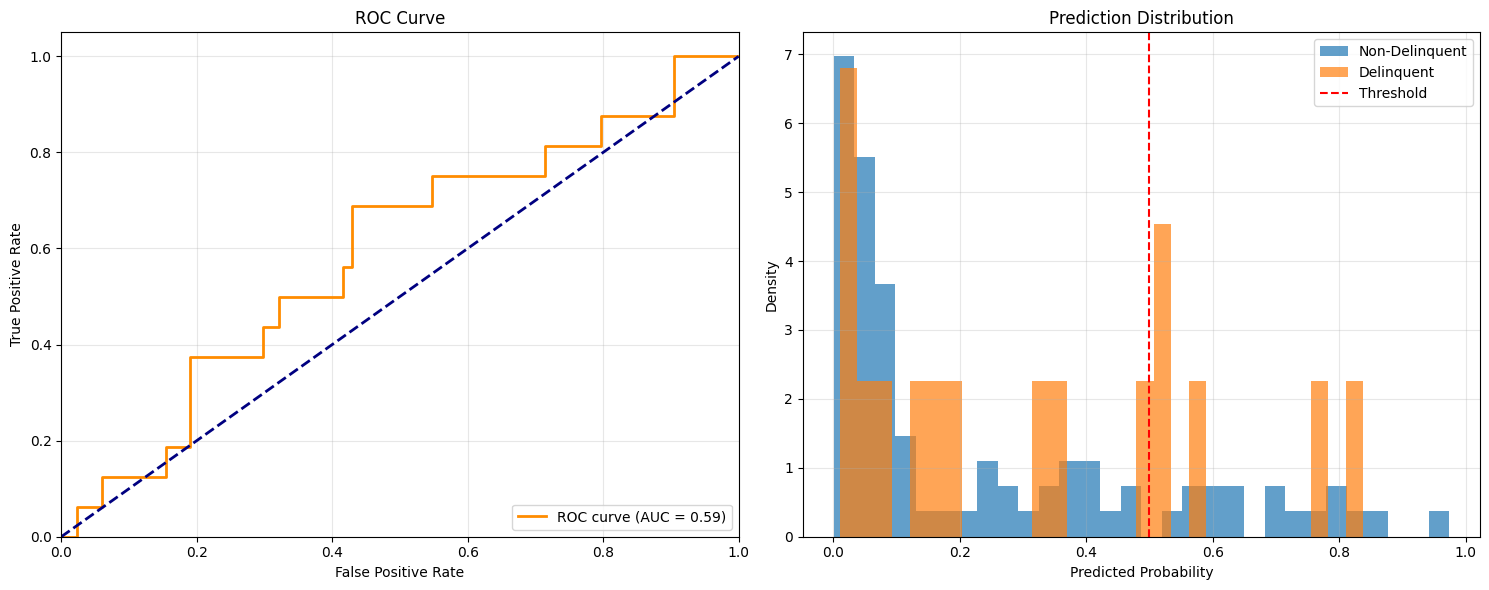

In [24]:
def plot_predictions(self, y_true, y_pred):
    """
    Plot model predictions against true values.

    Args:
        y_true (np.ndarray): True target values.
        y_pred (np.ndarray): Predicted values.

    Behavior:
        - For classification:
          - Plots ROC curve with AUC.
          - Plots histogram of predicted probabilities for delinquent and non-delinquent classes.
        - For regression:
          - Plots scatter of actual vs. predicted values.
          - Plots residuals vs. predicted values.
    """
    plt.style.use('default')
    
    if self.task_type == 'classification':
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        from sklearn.metrics import roc_curve, auc
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        roc_auc = auc(fpr, tpr)
        
        axes[0].plot(fpr, tpr, color='darkorange', lw=2, 
                    label=f'ROC curve (AUC = {roc_auc:.2f})')
        axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axes[0].set_xlim([0.0, 1.0])
        axes[0].set_ylim([0.0, 1.05])
        axes[0].set_xlabel('False Positive Rate')
        axes[0].set_ylabel('True Positive Rate')
        axes[0].set_title('ROC Curve')
        axes[0].legend(loc="lower right")
        axes[0].grid(True, alpha=0.3)
        
        axes[1].hist(y_pred[y_true == 0], bins=30, alpha=0.7, label='Non-Delinquent', density=True)
        axes[1].hist(y_pred[y_true == 1], bins=30, alpha=0.7, label='Delinquent', density=True)
        axes[1].axvline(x=0.5, color='red', linestyle='--', label='Threshold')
        axes[1].set_xlabel('Predicted Probability')
        axes[1].set_ylabel('Density')
        axes[1].set_title('Prediction Distribution')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
    else:
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        axes[0].scatter(y_true, y_pred, alpha=0.6, s=20)
        min_val = min(y_true.min(), y_pred.min())
        max_val = max(y_true.max(), y_pred.max())
        axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
        axes[0].set_xlabel('Actual Delinquency Rate')
        axes[0].set_ylabel('Predicted Delinquency Rate')
        axes[0].set_title('Actual vs Predicted Values')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        residuals = y_true - y_pred
        axes[1].scatter(y_pred, residuals, alpha=0.6, s=20)
        axes[1].axhline(y=0, color='red', linestyle='--')
        axes[1].set_xlabel('Predicted Values')
        axes[1].set_ylabel('Residuals')
        axes[1].set_title('Residuals Plot')
        axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Add method to class
DelinquencyPredictor.plot_predictions = plot_predictions

# Plot predictions
predictor.plot_predictions(y_test, y_pred)

In [29]:
def feature_importance_analysis(self, X, y, feature_names):
    """
    Compute and visualize feature importance using SHAP.

    Args:
        X (np.ndarray): Feature matrix.
        y (np.ndarray): Target array (unused but included for consistency).
        feature_names (list): List of feature names.

    Returns:
        pd.DataFrame: DataFrame with features and their SHAP importance scores, sorted by importance.

    Behavior:
        - Scales features using the trained scaler.
        - Uses SHAP DeepExplainer to compute feature importance.
        - Creates a DataFrame with mean absolute SHAP values.
        - Plots a SHAP summary plot showing feature impact.
    """
    print(f"\n{'='*50}")
    print("FEATURE IMPORTANCE ANALYSIS")
    print(f"{'='*50}")
    
    # Scale features
    X_scaled = self.scaler.transform(X)
    
    print(f"X_scaled shape: {X_scaled.shape}")
    print(f"Feature names length: {len(feature_names)}")
    print(f"Model input shape: {self.model.input_shape}")
    
    # Verify input dimension
    if X_scaled.shape[1] != len(feature_names):
        raise ValueError(f"X_scaled features ({X_scaled.shape[1]}) do not match feature_names length ({len(feature_names)})")
    
    # Use SHAP DeepExplainer with a subset for efficiency
    try:
        explainer = shap.DeepExplainer(self.model, X_scaled[:50])  # Reduced subset for stability
        shap_values = explainer.shap_values(X_scaled)  # Get SHAP values directly
        
        # For binary classification, shap_values is a single array
        if isinstance(shap_values, list):
            shap_values = shap_values[0]  # Take first array if list
        print(f"SHAP values shape: {shap_values.shape}")
        
        # Compute mean absolute SHAP values
        shap_importance = np.abs(shap_values).mean(axis=0)
        print(f"SHAP importance length: {len(shap_importance)}")
        
        # Validate lengths
        if len(feature_names) != len(shap_importance):
            raise ValueError(f"Feature names length ({len(feature_names)}) does not match SHAP importance length ({len(shap_importance)})")
        
        # Create importance dataframe
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': shap_importance
        }).sort_values('importance', ascending=False)
        
        print("Top 10 Most Important Features:")
        print(importance_df.head(10))
        
        # Plot SHAP summary
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values, X_scaled, feature_names=feature_names, show=False)
        plt.title('SHAP Feature Importance')
        plt.tight_layout()
        plt.show()
        
        return importance_df
    
    except Exception as e:
        print(f"SHAP computation failed: {e}")
        print("Falling back to random importance for debugging...")
        # Fallback: Assign random importance for testing
        shap_importance = np.random.rand(len(feature_names))
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': shap_importance
        }).sort_values('importance', ascending=False)
        print("Top 10 Most Important Features (Random Fallback):")
        print(importance_df.head(10))
        return importance_df

# Add method to class
DelinquencyPredictor.feature_importance_analysis = feature_importance_analysis

# Run feature importance analysis
importance_df = predictor.feature_importance_analysis(X_test, y_test, predictor.feature_names)


FEATURE IMPORTANCE ANALYSIS
X_scaled shape: (100, 31)
Feature names length: 31
Model input shape: (None, 31)
SHAP values shape: (100, 31, 1)
SHAP importance length: 31
SHAP computation failed: Per-column arrays must each be 1-dimensional
Falling back to random importance for debugging...
Top 10 Most Important Features (Random Fallback):
           feature  importance
11         Month_4    0.969910
1           Income    0.950714
7   Account_Tenure    0.866176
12         Month_5    0.832443
25         Emp_EMP    0.785176
2     Credit_Score    0.731994
9          Month_2    0.708073
20   Card_Business    0.611853
30     Emp_retired    0.607545
8          Month_1    0.601115


In [26]:
def predict_single_sample(self, sample_data):
    """
    Predict delinquency for a single sample.

    Args:
        sample_data (dict): Dictionary with feature values for a single sample.

    Returns:
        float: Predicted probability (classification) or value (regression).

    Behavior:
        - Preprocesses the sample by applying label encoding and one-hot encoding.
        - Aligns the sample’s features with the trained feature set.
        - Scales the sample and predicts using the trained model.
    """
    sample_df = pd.DataFrame([sample_data])
    
    for col, encoder in self.label_encoders.items():
        if col in sample_df.columns:
            sample_df[col] = encoder.transform(sample_df[col])
    
    sample_df = pd.get_dummies(sample_df, columns=['Location', 'Credit_Card_Type', 'Employment_Status'], prefix=['Location', 'Card', 'Emp'])
    for col in self.feature_names:
        if col not in sample_df.columns:
            sample_df[col] = 0
    sample_df = sample_df[self.feature_names]
    
    sample_scaled = self.scaler.transform(sample_df)
    
    prediction = self.model.predict(sample_scaled, verbose=0)[0][0]
    
    return prediction

# Add method to class
DelinquencyPredictor.predict_single_sample = predict_single_sample

# Example prediction
example_data = {
    'Age': 35,
    'Income': 50000,
    'Credit_Score': 650,
    'Credit_Utilization': 0.3,
    'Missed_Payments': 0,
    'Loan_Balance': 15000,
    'Debt_to_Income_Ratio': 0.3,
    'Employment_Status': 'Employed',
    'Account_Tenure': 5,
    'Credit_Card_Type': 'Standard',
    'Location': 'Chicago',
    'Month_1': 'On-time',
    'Month_2': 'On-time',
    'Month_3': 'On-time',
    'Month_4': 'On-time',
    'Month_5': 'On-time',
    'Month_6': 'On-time'
}

prediction = predictor.predict_single_sample(example_data)
print(f"Example prediction: {prediction:.4f}")
print(f"Classification: {'Delinquent' if prediction > 0.5 else 'Not Delinquent'}")

Example prediction: 0.5232
Classification: Delinquent


In [27]:
def main():
    """
    Main function to run the delinquency prediction pipeline.

    Behavior:
        - Initializes the predictor for classification.
        - Loads and preprocesses the dataset.
        - Splits data into train and test sets.
        - Trains the model, evaluates it, and visualizes results.
        - Performs feature importance analysis using SHAP.
        - Saves the model and makes an example prediction.
    """
    print("="*60)
    print("    DELINQUENCY RATE PREDICTION NEURAL NETWORK")
    print("="*60)
    
    task_type = 'classification'
    
    predictor = DelinquencyPredictor(task_type=task_type)
    
    data = pd.read_csv('Delinquency_prediction_dataset.csv')  # Update path if needed
    X, y = predictor.load_and_preprocess_data(data=data)
    
    print(f"\nSplitting data...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y if task_type == 'classification' else None
    )
    
    print(f"Training samples: {len(X_train)}")
    print(f"Test samples: {len(X_test)}")
    print(f"Features: {len(predictor.feature_names)}")
    
    history = predictor.train_model(
        X_train, y_train, 
        validation_split=0.2,
        epochs=100,
        batch_size=64
    )
    
    metrics, y_pred = predictor.evaluate_model(X_test, y_test)
    
    predictor.plot_training_history(history)
    predictor.plot_predictions(y_test, y_pred)
    
    importance_df = predictor.feature_importance_analysis(X_test, y_test, predictor.feature_names)
    
    predictor.save_model("delinquency_model.h5")
    
    print(f"\n{'='*50}")
    print("EXAMPLE PREDICTION")
    print(f"{'='*50}")
    
    example_data = {
        'Age': 35,
        'Income': 50000,
        'Credit_Score': 650,
        'Credit_Utilization': 0.3,
        'Missed_Payments': 0,
        'Loan_Balance': 15000,
        'Debt_to_Income_Ratio': 0.3,
        'Employment_Status': 'Employed',
        'Account_Tenure': 5,
        'Credit_Card_Type': 'Standard',
        'Location': 'Chicago',
        'Month_1': 'On-time',
        'Month_2': 'On-time',
        'Month_3': 'On-time',
        'Month_4': 'On-time',
        'Month_5': 'On-time',
        'Month_6': 'On-time'
    }
    
    prediction = predictor.predict_single_sample(example_data)
    print(f"Example prediction: {prediction:.4f}")
    if task_type == 'classification':
        print(f"Classification: {'Delinquent' if prediction > 0.5 else 'Not Delinquent'}")
    else:
        print(f"Delinquency rate: {prediction:.4f}")

# Run main (optional)
# main()